# **Detecting Twitter Hate Speech**
Michael Ainsworth (mainswo3), Nico Ivanov (nivanov4), Matthew Ost (most1), Parker Treadway (ptreadw1)
\
\
Github Link: https://github.com/Michael-Ainsworth/twitter-hate-speech-detection.git

## 1. Outline and Deliverables

### Project Description
The motivation for this project is to build a reliable pipeline that can identify and protect twitter users from hateful speech. To achieve this goal, we will experiment with various tweet vectorization techniques and evaluate performance on a logistic regression model, a random forest model, an SVM, a Adaboost model, a Multi-Layer Perceptron (MLP), and a Convolutional Neural Network (CNN).
\
\
To download the pre-trained GloVe embeddings, visit this link: https://nlp.stanford.edu/projects/glove/ Go to the "Download pre-trained word vectors" section and select the download you want. For this project, we use glove.6b.zip (trained on Wikipedia 2014 + Gigaword 5).
\
\
Resources: https://github.com/minimaxir/char-embeddings (used for pretrained character embeddings), https://towardsdatascience.com/pytorch-tabular-binary-classification-a0368da5bb89 (inspired code for MLP)

### Deliverables
Finished Deliverables:
* Pipeline for processing, cleaning, and vectorizing tweets using 4 vectorization techniques: TFIDF Word, TFIDF Char, Char Embeddings, and word-based Document Embeddings
* Implemented logistic regression, random forest, SVM, AdaBoost,  and multi-layer perceptron models (more difficult than expected)
* Also implemented a hyperparameter optimization framework
* Implemented a data augmentation method using WordNet to replace meaning-bearing tokens with appropriate synonyms.
* Implemented a CNN classifier
* FATE analysis on our best model.

Unachieved:
* F1 score of 0.5 for the hate speech class

Cut Deliverables:
* LSTM autoencoder trained on a large dataset of unlabeled tweets and used as the base for a classifier on our original dataset. This was too difficult to complete and has been cut from the program.


## 2. Preliminaries 

### The Problem at hand
With the rise of social media, hate speech has become significantly more visible than ever before and holds a detrimental effect over the social media experience. Hate speech is categorized as any form of speech that negatively targets a person or group of people based on religion, race, ethnicity, nationality, or any other identifier [1].
\
\
Social media platforms have methods of reviewing and removing hate speech, but this usually is done manually and is very time intensive. A machine learning solution could be used to identify a hateful post much quicker.
\
\
Ethically, incorrectly labelling normal speech as hate speech could pose real questions about the platform's freedom of speech. This is especially possible with social media because of the many colloquialisms used that occur in both hateful and positive contexts. We will later perform a FATE analysis to better understand the ethical questions that our project is challenged with.
\
\
This problem is similar to homework 4, where we implemented TFIDF and an SVM to classify the topic of a news article. We are also adding other methods of feature extraction, however, such as character TFIDF, character embeddings, and document embeddings. Furthermore, we are testing these feature extraction methods on several models we learned in class, i.e logistic regression, random forest, SVM, Multi-layer perceptron, and convolutional neural network.



### Dataset
Source: https://data.world/thomasrdavidson/hate-speech-and-offensive-language
\
\
Stored as `twitter_hate.csv`, our data is a collection of tweets labeled as 'offensive language', 'hate speech', or neither ('normal language').

Dataset Statistics:

*   Total tweets: 24,783
*   Class 0 tweets (hate speech): 1430
*   Class 1 tweets (offensive language): 19190
*   Class 2 tweets (normal language): 4163

In [ ]:
import pandas as pd
import numpy as np

df=pd.read_csv('twitter_hate.csv', sep=',',header=None)
classes = df[5]
classes = classes[1:].to_numpy()

unique, counts = np.unique(classes, return_counts=True)

print("Total number of tweets: " + str(classes.size))
for i in range(3):
  print("Class " + str(unique[i]) + " has " + str(counts[i]) + " examples.")

Total number of tweets: 24783
Class 0 has 1430 examples.
Class 1 has 19190 examples.
Class 2 has 4163 examples.


Dataset Examples:





In [ ]:
tweets = df[6]
tweets = tweets[1:]

print("Example for class 0: " + tweets[701])
print("Example for class 1: " + tweets[743])
print("Example for class 2: " + tweets[764])

Example for class 0: #Dutch people who live outside of #NewYorkCity are all white trash.
Example for class 1: #NationalCatDay ...sure. Celebrate over 1 BILLION bird deaths and blame it on #climatechange you fuckin' #commies.
Example for class 2: #RedSox, focus on the #Orioles that knocked you out last year, and not your hatred of the #Yankees for um-teen years! LOL!


For this project we decided to focus specifically on identifying hate speech. So, as we will describe later towards the models portion of this notebook, we decided to make this a binary classification problem by grouping class 1 (offensive language) and class 2 (normal language) together. 

As we saw, we have far fewer examples of hate speech, making classification difficult. Later we will discuss how we decided to deal with this problem.

### Preprocessing Pipeline
To preprocess our tweets, we created a Python class called Data in a file called `preprocessing.py`. The Data class fascilitates in loading our data and correctly storing our raw tweets. It then calls several methods that process the raw tweets and stores the new processed tweets.
\
\
Our preprocessing pipeline calls the following methods in this order:


1.   _remove_call_outs(): Removes any '@person' tags.
2.   _fix_escaped_tokens(): Replaces standard escaped tokens with human-readable versions and surround emojis with <>.
3.   _tokenize(): Splits a tweet into a list of tokens including punctuation, i.e `"I'm a dog"` -> `["I", "'", "m", "a", "dog"]`
4.   _remove_stopwords(): Removes stopwords from the tweet, i.e words such as "me", "do", "ourselves". These words generally have less predictive power but show up a lot.




Preprocessing the data and showing an example:

In [ ]:
import sys
sys.path.append('./preprocessing.py')
import preprocessing

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\parke\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Here we create one Data object for each feature extraction method we implemented (4 total).

In [ ]:
DATAFILE = "./twitter_hate.csv"
D1 = preprocessing.Data(DATAFILE, preprocess=True)
D2 = preprocessing.Data(DATAFILE, preprocess=True)
D3 = preprocessing.Data(DATAFILE, preprocess=True)
D4 = preprocessing.Data(DATAFILE, preprocess=True)

print("Example of a non-preprocessed tweet: \n" + D1.raw_tweets[0])
print("\nThe same tweet after preprocessing: \n" + str(D1.tweets[0]))

Example of a non-preprocessed tweet: 
!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out..

The same tweet after preprocessing: 
['!!', 'rt', 'woman', 'complain', 'cleaning', 'house', '.', '&', 'man', 'always', 'take', 'trash', '..']


### Data Augmentation
One of the big drawbacks of our dataset is how imbalanced it is. We decided to perform data augmentation on our dataset by duplicating tweets of the hate speech class and replacing some of the words with synonyms using WordNet. This allows us to increase the number of examples we have for this class. We only want to augment our training data to keep our test data realistic. So, before augmenting we will perform train test splits on our data.

Here we create a random seed for our train_test_splits.

In [ ]:
import random
seed = random.randint(1,1001)

In [ ]:
D1._train_test_split(seed)
D2._train_test_split(seed)
D3._train_test_split(seed)
D4._train_test_split(seed)

Now that we have preprocessed our data and split it intro train and test sets, we can perform data augmentation:

In [ ]:
#Saving unique values before data augmentation for later comparison
unique_train, counts_train = np.unique(np.array(D1.train_labels), return_counts=True)
unique_test, counts_test = np.unique(np.array(D1.test_labels), return_counts=True)

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

D1.augment_data()
D2.augment_data()
D3.augment_data()
D4.augment_data()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\parke\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\parke\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
100%|██████████| 19826/19826 [00:01<00:00, 14014.33it/s]


Train Data before and after data augmentation:

In [ ]:
unique2, counts2 = np.unique(np.array(D1.train_labels), return_counts=True)
print("Number of class 0 (hate speech) train tweets before data augmentation: " + str(counts_train[0]))
print("Number of class 0 (hate speech) train tweets after data augmentation: " + str(counts2[0]))
print("\n")
print("Number of class 1 (offensive language) train tweets before data augmentation: " + str(counts_train[1]))
print("Number of class 1 (offensive language) train tweets after data augmentation: " + str(counts2[1]))
print("\n")
print("Number of class 2 (normal language) train tweets before data augmentation: " + str(counts_train[2]))
print("Number of class 2 (normal language) train tweets after data augmentation: " + str(counts2[2]))

Number of class 0 (hate speech) train tweets before data augmentation: 1154
Number of class 0 (hate speech) train tweets after data augmentation: 5104


Number of class 1 (offensive language) train tweets before data augmentation: 15379
Number of class 1 (offensive language) train tweets after data augmentation: 15379


Number of class 2 (normal language) train tweets before data augmentation: 3293
Number of class 2 (normal language) train tweets after data augmentation: 3293


In [ ]:
unique2, counts2 = np.unique(np.array(D1.test_labels), return_counts=True)
print("Number of class 0 (hate speech) test tweets before data augmentation: " + str(counts_test[0]))
print("Number of class 0 (hate speech) test tweets after data augmentation: " + str(counts2[0]))
print("\n")
print("Number of class 1 (offensive language) test tweets before data augmentation: " + str(counts_test[1]))
print("Number of class 1 (offensive language) test tweets after data augmentation: " + str(counts2[1]))
print("\n")
print("Number of class 2 (normal language) test tweets before data augmentation: " + str(counts_test[2]))
print("Number of class 2 (normal language) test tweets after data augmentation: " + str(counts2[2]))

Number of class 0 (hate speech) test tweets before data augmentation: 276
Number of class 0 (hate speech) test tweets after data augmentation: 276


Number of class 1 (offensive language) test tweets before data augmentation: 3811
Number of class 1 (offensive language) test tweets after data augmentation: 3811


Number of class 2 (normal language) test tweets before data augmentation: 870
Number of class 2 (normal language) test tweets after data augmentation: 870


### Balancing the Dataset
As you can see, despite increasing the number of hate-speech examples we have, we still have a very imbalanced dataset. We counteract this by using Data._balance_dataset() which randomly removes tweets from classes 1 and 2 until we have about a 50-50 split.
\
\
Note: We only balance our training data.

In [ ]:
#Saving unique values before data augmentation for later comparison
unique2, counts2 = np.unique(np.array(D1.train_labels), return_counts=True)

In [ ]:
D1._balance_dataset()
D2._balance_dataset()
D3._balance_dataset()
D4._balance_dataset()

In [ ]:
unique3, counts3 = np.unique(np.array(D1.train_labels), return_counts=True)
print("Number of class 0 (hate speech) tweets before data balance: " + str(counts2[0]))
print("Number of class 0 (hate speech) tweets after data balance: " + str(counts3[0]))
print("\n")
print("Number of class 1 (offensive language) tweets before data balance: " + str(counts2[1]))
print("Number of class 1 (offensive language) tweets after data balance: " + str(counts3[1]))
print("\n")
print("Number of class 2 (normal language) tweets before data balance: " + str(counts2[2]))
print("Number of class 2 (normal language) tweets after data balance: " + str(counts3[2]))

Number of class 0 (hate speech) tweets before data balance: 5104
Number of class 0 (hate speech) tweets after data balance: 5104


Number of class 1 (offensive language) tweets before data balance: 15379
Number of class 1 (offensive language) tweets after data balance: 4178


Number of class 2 (normal language) tweets before data balance: 3293
Number of class 2 (normal language) tweets after data balance: 926


## 3. Methods, Models, and Evaluation

### Feature Extraction
We now have preprocessed and augmented tweets. We have to transform these tweets into feature vectors. We used the following feature extraction methods:


1.   TFIDF word vectorizer
2.   TFIDF character vectorizer
3.   Character embeddings
4.   Document embeddings



#### Note:
In the original data, class 0 is hate speech, class 1 is offensive language, and class 2 is normal language. Because we are doing binary classification on hate speech, we will combine class 1 and 2 below. Furthermore, because we are attempting to specifically identify hate speech, we will make the hate speech class 1 and non-hate speech class 0, so that our FP, FN, TP, and FP metrics make sense.

In [ ]:
sys.path.append('./vectorize.py')
import vectorize

1) TFIDF word vectorizer
<br>
<br>
This vectorizer computes TFIDF weights on the pre-processed dataset using  bigram counts at the word level. We built a wrapper class around Scikit-Learn's TFIDFVectorizer to make life easy. As mentioned above, we fit the TFIDF vectorizer on the training data to prevent data leakage. Given the large number of unique tokens, we restrict our vocabulary to terms with a document frequency between 0.001 and 0.9. This reduced the dimensionality of our feature vectors from ~30k to 1,407. TFIDF is a well-known method in natural language processing, so we use it as our primary feature extraction method. It is inherently limiting in that it treats each tweet as a bag of words, rather than attempting to model the complex linguistic dependencies. We attempt to compensate for this by counting bigrams instead of unigrams.

In [ ]:
ngram_range = (2,2)
word_V = vectorize.TFIDFWordVectorizer(D1, ngram_range)

word_y_train = np.array(D1.train_labels).astype(np.float)
word_y_test = np.array(D1.test_labels).astype(np.float)

word_y_train = np.where(word_y_train < 0.5, 1, 0)
word_y_test = np.where(word_y_test < 0.5, 1, 0)

word_X_train, word_X_test = word_V.vectorize()
print('Train Word TFIDF shape: ', word_X_train.shape)
print('Train Word TFIDF labels shape: ', np.array(word_y_train).shape)
print('Test Word TFIDF shape: ', word_X_test.shape)
print('Test Word TFIDF labels shape: ', np.array(word_y_test).shape)

Train Word TFIDF shape:  (10208, 574)
Train Word TFIDF labels shape:  (10208,)
Test Word TFIDF shape:  (4957, 574)
Test Word TFIDF labels shape:  (4957,)


2) TFIDF character vectorizer
<br>
<br>
This vectorizer computes TFIDF weights on the pre-processed dataset at the character level. It counts character bigrams. We restrict our vocabulary to tokens with the same document frequency range as used for the TFIDF word vectorization scheme, which resulted in vectors of dimension 3,903.

In [ ]:
ngram_range = (2,2)
char_V = vectorize.TFIDFCharVectorizer(D2, ngram_range)

char_y_train = np.array(D2.train_labels).astype(np.float)
char_y_test = np.array(D2.test_labels).astype(np.float)

char_y_train = np.where(char_y_train < 0.5, 1, 0)
char_y_test = np.where(char_y_test < 0.5, 1, 0)

char_X_train, char_X_test = char_V.vectorize()
print('Train Character TFIDF shape: ', char_X_train.shape)
print('Train Character TFIDF labels shape: ', np.array(char_y_train).shape)
print('Test Character TFIDF shape: ', char_X_test.shape)
print('Test Character TFIDF labels shape: ', np.array(char_y_test).shape)

Train Character TFIDF shape:  (10208, 868)
Train Character TFIDF labels shape:  (10208,)
Test Character TFIDF shape:  (4957, 868)
Test Character TFIDF labels shape:  (4957,)


3) Character embeddings
<br>
<br>
This vectorization method uses pre-trained character embeddings from resource 1 (in resources section above). These embeddings were 300-dimensional. For each tweet, we create a single embedding vector as an unweighted average of the embeddings of each character present in the tweet. Note that we do not limit ourselves to unique characters- a character that appears in the tweet multiple times will factor into the calculation multiple times. As with TFIDF-character, we used this method because twitter data is noisy, and we hypothesized that working at the character level instead of the word level could help encode the meaning of each tweet.

In [ ]:
char_emb_V = vectorize.CharEmbeddings(dataset=D3, emb_path='./', emb_dim=5)
char_emb_V.parse(path='./')
char_emb_X_train, char_emb_X_test = char_emb_V.vectorize()

char_emb_y_train = np.array(D3.train_labels).astype(np.float)
char_emb_y_test = np.array(D3.test_labels).astype(np.float)
char_emb_y_train = np.where(char_emb_y_train < 0.5, 1, 0)
char_emb_y_test = np.where(char_emb_y_test < 0.5, 1, 0)

print("Train Character Embeddings shape: ", char_emb_X_train.shape)
print("Train Character Embeddings labels shape: ", char_emb_y_train.shape)
print("Test Character Embeddings shape: ", char_emb_X_test.shape)
print("Test Character Embeddings labels shape: ", char_emb_y_test.shape)

Train Character Embeddings shape:  (10208, 5)
Train Character Embeddings labels shape:  (10208,)
Test Character Embeddings shape:  (4957, 5)
Test Character Embeddings labels shape:  (4957,)


4) Document embeddings
<br>
<br>
This vectorization scheme operates on the pre-processed data and uses pre-trained word embeddings to compute a single vector representing each tweet. We use 50-dimensional pre-trained GloVe embeddings that were trained on a Wikipedia dataset. For a given tweet, it's embedding vector is computed as an unweighted average of the embeddings of the words present in that tweet. If a word appears multiple times, it will factor into the calculation multiple times. It is possible that a pre-processed does not contain any words that have a corresponding GloVe embedding. In this case, we drop that tweet from the dataset. Thus our train test splits for this feature extraction method have slightly fewer examples (~150 fewer examples, which seems insignificant). With this method, our hope was that our pre-processing and the pre-trained embeddings would sufficiently represent each tweet. The pre-processing would identify only meaning-bearing words, and the average of the specialized embeddings would concisely encode that meaning in a single vector.

In [ ]:
doc_emb_V = vectorize.DocEmbeddings(D4, emb_path="./", emb_dim=50)
doc_emb_X_train, doc_emb_X_test = doc_emb_V.vectorize(success_rate=True)

doc_emb_y_train = np.take(np.array(D4.train_labels), doc_emb_V.train_vector_indices)
doc_emb_y_test = np.take(np.array(D4.test_labels), doc_emb_V.test_vector_indices)

doc_emb_y_train = np.array(doc_emb_y_train).astype(np.float)
doc_emb_y_test = np.array(doc_emb_y_test).astype(np.float)
doc_emb_y_train = np.where(doc_emb_y_train < 0.5, 1, 0)
doc_emb_y_test = np.where(doc_emb_y_test < 0.5, 1, 0)

print("Train Document Embeddings shape: ", doc_emb_X_train.shape)
print("Train Document Embeddings labels shape: ", doc_emb_y_train.shape)
print("Test Document Embeddings shape: ", doc_emb_X_test.shape)
print("Test Document Embeddings labels shape: ", doc_emb_y_test.shape)

Loading GloVe word embedding from .//glove.6B.50d.txt
Found embeddings for 88.6% of all possible tokens
Train Document Embeddings shape:  (10164, 50)
Train Document Embeddings labels shape:  (10164,)
Test Document Embeddings shape:  (4933, 50)
Test Document Embeddings labels shape:  (4933,)


### Experimental Setup

#### Original Experiment Metrics
The original experiment conducted by [Thomas Davidson](https://github.com/t-davidson/hate-speech-and-offensive-language) focused on the multiclass setting used a variety of evaluation metrics including precision, recall, F1 score, and accuracy. 
<br>

#### Our Experiment Metrics
In our case, we are translating this to a binary classification problem, where the raw data contains heavily imbalanced classes. When classes are imbalanced, metrics such as accuracy and ROC curves are less informative. Better metrics for evaluation include precision, recall, F1 score, and precision-recall curves. These metrics are better suited for imbalanced data because they do not rely on the number of True Negatives.

In terms of quantifying model success, we will focus on F1 score.

#### Our Experiment Pipeline
When cleaning, vectorizing, and normalizing our data, it is important that we maintain a clear pipeline that prevents information about the target classes from being available to the model. To facilitate this aim, we broke our processed data into a 80/20 train_test_split (shown earlier).
<br>
<br>
Using our models, data will be trained using the 80% train split and evaluated on the 20% test split. To perform hyperparameter tuning, 5-fold cross validation will be used on our training class.
<br>
<br>
Loss functions for individual models will be explored in more detail in the Models section.

### Baselines

No established baselines were available for the binary classification setting. Therefore, we chose to establish these baselines ourselves using a TFIDF character vectorizer and our finalized data cleaning pipeline. TFIDF is a sklearn package and there exists sufficient literature and documentation to show high success rates on text datasets. Therefore, we feel TFIDF character is a suitable choice for establishing a baseline model. To run our TFIDF baseline vectorization, we used a ngram_range of (2,2).

\
In addition, these baseline models are built with the raw data classes. Therefore, no data augmentation was used. This data imbalance may have caused significant impacts on these baselines, but it was representative of the original data provided.

\
To evaluate this vectorized dataset, we used the following classifiers:

1.   Logistic Regression (Scikit-Learn)
2.   Random forest (Scikit-Learn)
3.   SVM (Scikit-Learn)
4.   Adaboost (Scikit-Learn)
5.   Multilayer perceptron (PyTorch)

\
Each of these classifiers will be studied to develop a single optimal model. For setting a baseline, we will train all classifiers to establish a unique baseline for each model.


In [ ]:
sys.path.append('./models.py')
import models
sys.path.append('./metrics.py')
import metrics

baseline_data = preprocessing.Data(DATAFILE, preprocess=True)

baseline_data._train_test_split(seed)
ngram_range = (2,2)
baseline_tfidf_char = vectorize.TFIDFCharVectorizer(baseline_data, ngram_range)

baseline_y_train = np.array(baseline_data.train_labels).astype(np.float)
baseline_y_test = np.array(baseline_data.test_labels).astype(np.float)
baseline_y_train = np.where(baseline_y_train < 0.5, 1, 0)
baseline_y_test = np.where(baseline_y_test < 0.5, 1, 0)

baseline_X_train, baseline_X_test = baseline_tfidf_char.vectorize()


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\parke\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Logitstic Regression Baseline

TN:  4664 FP:  17 FN:  260 TP:  16
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      4681
           1       0.48      0.06      0.10       276

    accuracy                           0.94      4957
   macro avg       0.72      0.53      0.54      4957
weighted avg       0.92      0.94      0.92      4957



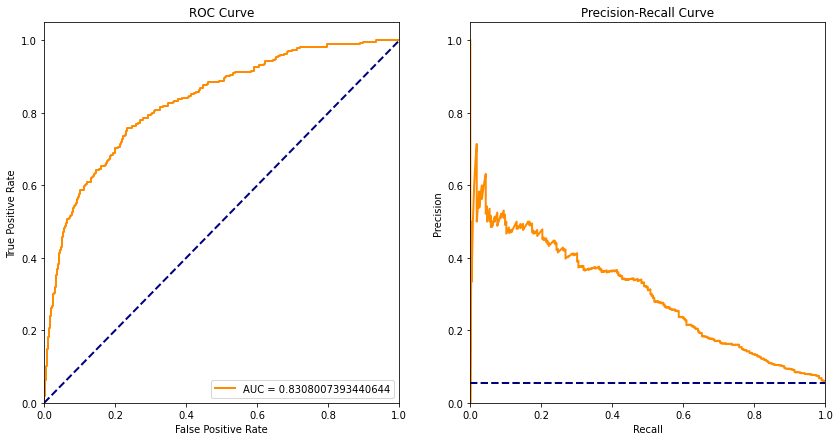

In [ ]:
baseline_lr = models.LogisticRegressionModel()
baseline_lr.fit(baseline_X_train, baseline_y_train)
score, preds, raw_preds = baseline_lr.predict(baseline_X_test, baseline_y_test)
metrics.binary_metrics(baseline_y_test, raw_preds, preds)

Random Forest Baseline

TN:  4675 FP:  6 FN:  272 TP:  4
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      4681
           1       0.40      0.01      0.03       276

    accuracy                           0.94      4957
   macro avg       0.67      0.51      0.50      4957
weighted avg       0.91      0.94      0.92      4957



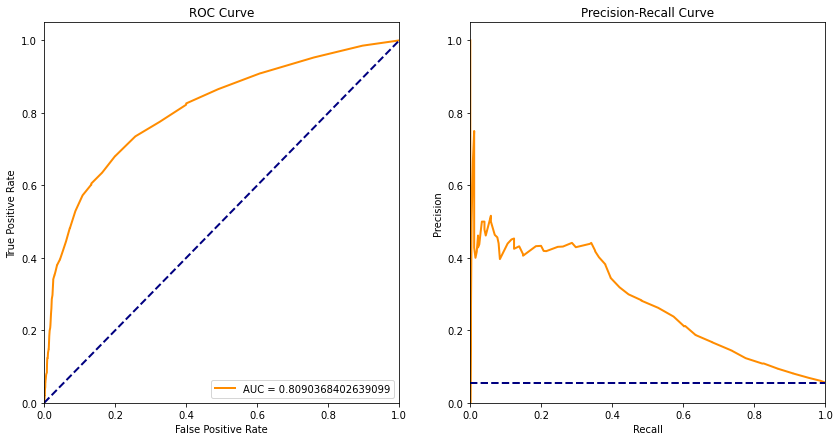

In [ ]:
baseline_rf = models.RandomForestModel()
baseline_rf.fit(baseline_X_train, baseline_y_train)
score, preds, raw_preds = baseline_rf.predict(baseline_X_test, baseline_y_test)
metrics.binary_metrics(baseline_y_test, raw_preds, preds)

SVM Baseline

<class 'numpy.matrix'>
<class 'numpy.ndarray'>
TN:  4678 FP:  3 FN:  272 TP:  4
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      4681
           1       0.57      0.01      0.03       276

    accuracy                           0.94      4957
   macro avg       0.76      0.51      0.50      4957
weighted avg       0.92      0.94      0.92      4957



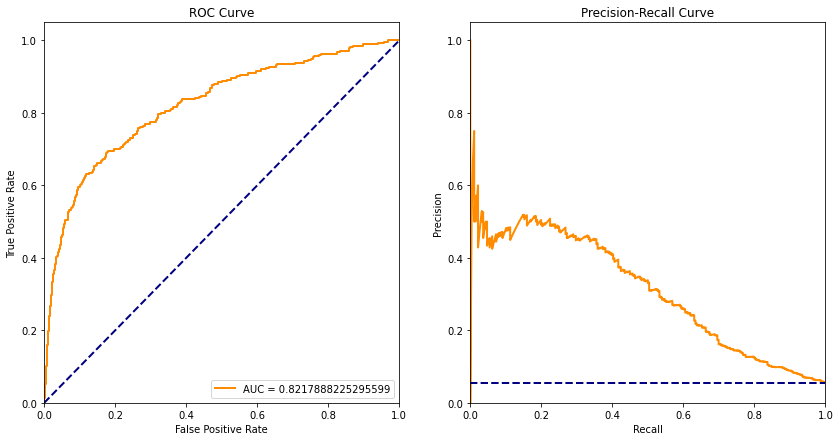

In [ ]:
baseline_svm = models.SVMModel()
baseline_svm.fit(baseline_X_train, baseline_y_train)
score, preds, raw_preds = baseline_svm.predict(baseline_X_test.todense(), baseline_y_test)
metrics.binary_metrics(baseline_y_test, raw_preds, preds)

Adaboost Baseline

TN:  4640 FP:  41 FN:  247 TP:  29
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      4681
           1       0.41      0.11      0.17       276

    accuracy                           0.94      4957
   macro avg       0.68      0.55      0.57      4957
weighted avg       0.92      0.94      0.93      4957



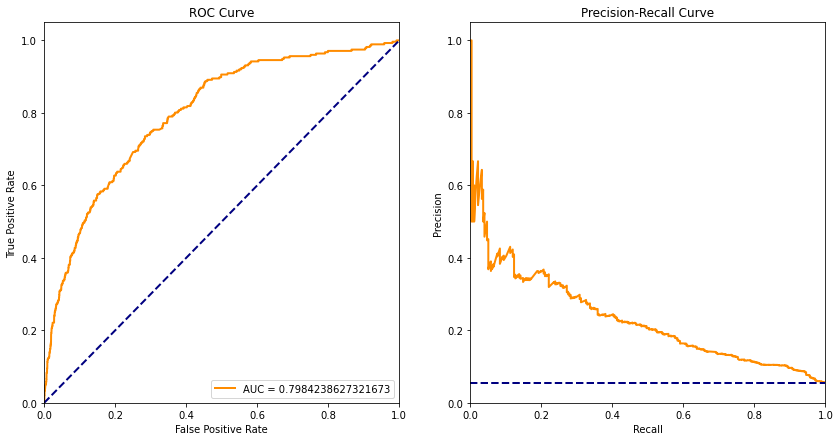

In [ ]:
baseline_adaboost = models.AdaBoostModel()
baseline_adaboost.fit(baseline_X_train, baseline_y_train)
score, preds, raw_preds = baseline_adaboost.predict(baseline_X_test, baseline_y_test)
metrics.binary_metrics(baseline_y_test, raw_preds, preds)

Multi-Layer Perceptron Baseline

cpu
binaryClassification(
  (layer_1): Linear(in_features=906, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Epoch 001: | Loss: 0.36886 | Acc: 88.381
Epoch 002: | Loss: 0.16502 | Acc: 94.474
Epoch 003: | Loss: 0.12681 | Acc: 95.471
Epoch 004: | Loss: 0.09383 | Acc: 96.368
Epoch 005: | Loss: 0.06876 | Acc: 97.365
Epoch 006: | Loss: 0.05584 | Acc: 97.903
Epoch 007: | Loss: 0.04126 | Acc: 98.442
Epoch 008: | Loss: 0.03139 | Acc: 98.887
Epoch 009: | Loss: 0.02567 | Acc: 99.058
Epoch 010: | Loss: 0.02373 | Acc: 99.181
TN:  4575 FP:  106 FN:  230 TP:  46
              precision    recall  f1-score   support

           0       0.95  

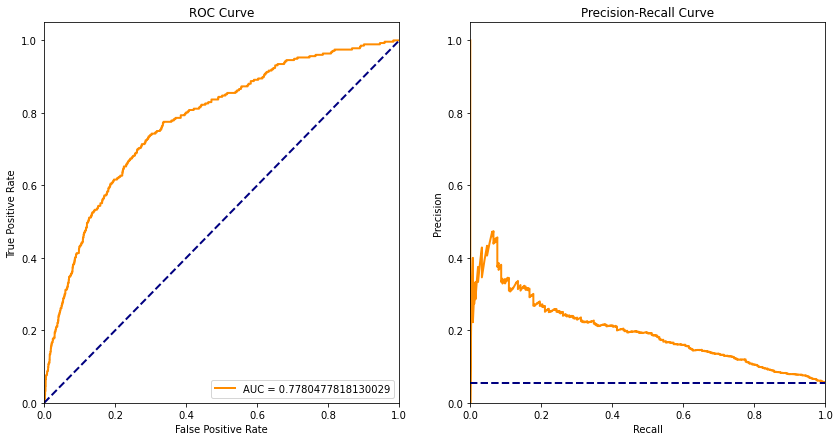

In [ ]:
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import torch

scaler = StandardScaler()
baseline_NN_X_train = scaler.fit_transform(baseline_X_train)
baseline_NN_X_test = scaler.fit_transform(baseline_X_test.todense())

train_data = models.trainData(torch.FloatTensor(baseline_NN_X_train), torch.FloatTensor(baseline_y_train))
test_data = models.testData(torch.FloatTensor(baseline_NN_X_test))

train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

model = models.train_neural_net(train_loader, 10, 0.001, baseline_X_train.shape)

preds, raw_preds = models.test_neural_net(model, test_loader)

metrics.binary_metrics(baseline_y_test, raw_preds, preds)

To contextualize these baselines, we can compare them back to the original analysis by Thomas Davidson. Although Davidson focused on the multiclass, we can still consider his F1 score for each respective class. According to his personal repository, Davidson achieved the following F1 score for each class:


- `Hate Speech F1 Score`:    **0.51**
- `Offensive Language F1 Score`:   **0.94**
- `Normal Language F1 Score`:   **0.89**

As seen from our baselines, our models perform particularly poorly. Even though we are solving the binary setting, which in theory should be easier, we still have a far lower F1 score on Hate Speech. This demonstrates some of the difficulties of working with imbalanced data. In addition, this further motivates the use of additional methods such as data augmentation and model hyperparameter tuning.

### Classification Models

As mentioned above in the Baselines section, our model building focused on five distinct models: Logistic Regression, Random Forest, SVM, AdaBoost, and Multilayer Perceptron.

Each of these models were trained on all unique vectorization techniques (TFIDF Word, TFIDF Char, Document Embeddings, Character Embeddings) with and without data augmentation. Based on these original results, we will fine tune our best performing methods and models to yield our final classifiers.

Furthermore, we implemented a convolutional nueral network. This CNN takes in raw data so we cannot use our vectorizers. This is because data augmentation works on fully preprocessed and tokenized tweets, which cannot be inputted into the CNN.


1) Logistic Regression

The first model implemented was logistic regression. The loss function used for logistic regression is log loss. 

We chose to utilize this model first because it is easy to implement, efficient for training, and it doesn't make assumptions about the class distribution.

The original model parameters (pre-hyperparameter tuning) included:

`C` = 1

`fit_intercept` = True

`solver` = 'lbfgs'

This model was trained as shown below:

TFIDF word logistic regression accuracy:  0.8501109542061731
TN:  4146 FP:  535 FN:  208 TP:  68
              precision    recall  f1-score   support

           0       0.95      0.89      0.92      4681
           1       0.11      0.25      0.15       276

    accuracy                           0.85      4957
   macro avg       0.53      0.57      0.54      4957
weighted avg       0.91      0.85      0.88      4957



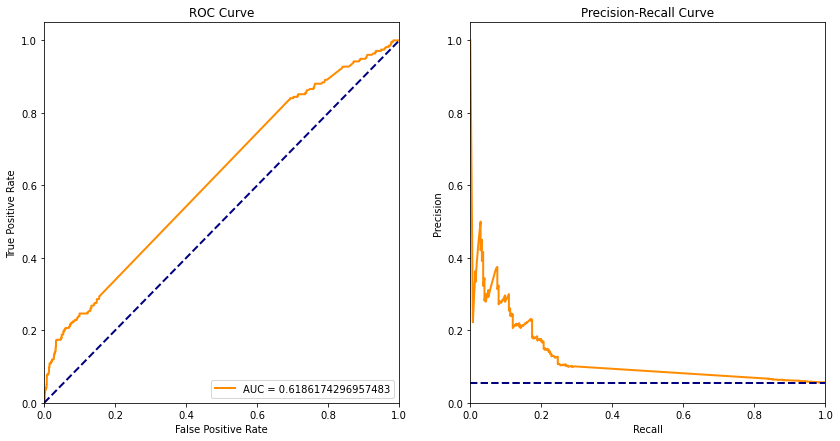

TFIDF Character logistic regression accuracy:  0.7883800685898729
TN:  3720 FP:  961 FN:  88 TP:  188
              precision    recall  f1-score   support

           0       0.98      0.79      0.88      4681
           1       0.16      0.68      0.26       276

    accuracy                           0.79      4957
   macro avg       0.57      0.74      0.57      4957
weighted avg       0.93      0.79      0.84      4957



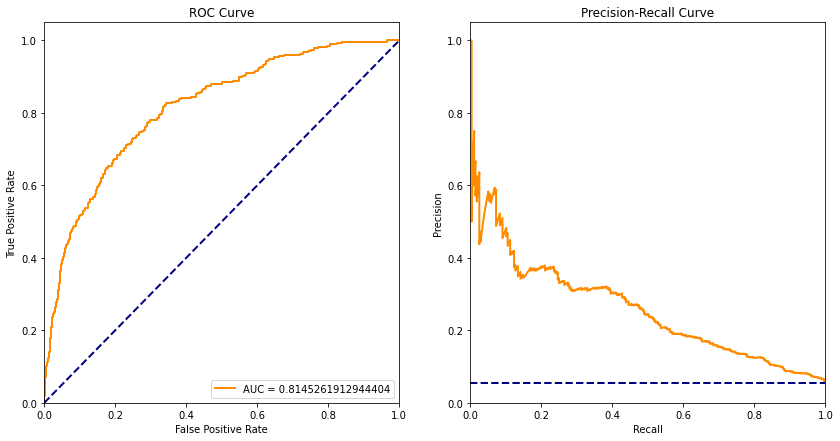

Character Embeddings logistic regression accuracy:  0.38833972160581
TN:  1737 FP:  2944 FN:  88 TP:  188
              precision    recall  f1-score   support

           0       0.95      0.37      0.53      4681
           1       0.06      0.68      0.11       276

    accuracy                           0.39      4957
   macro avg       0.51      0.53      0.32      4957
weighted avg       0.90      0.39      0.51      4957



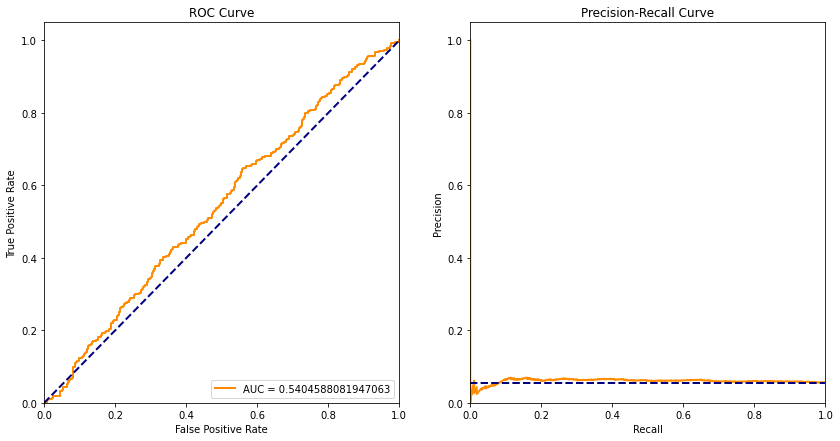

Document Embeddings logistic regression accuracy:  0.6801135211838638
TN:  3194 FP:  1468 FN:  110 TP:  161
              precision    recall  f1-score   support

           0       0.97      0.69      0.80      4662
           1       0.10      0.59      0.17       271

    accuracy                           0.68      4933
   macro avg       0.53      0.64      0.49      4933
weighted avg       0.92      0.68      0.77      4933



C:\Users\parke\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


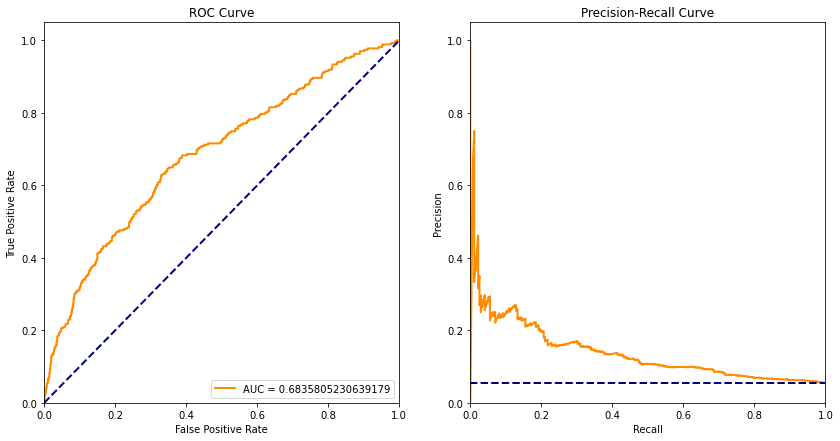

In [ ]:
lr = models.LogisticRegressionModel()

#TFIDF Word
lr.fit(word_X_train, word_y_train)
score, preds, raw_preds = lr.predict(word_X_test, word_y_test)
print("TFIDF word logistic regression accuracy: ", score)
metrics.binary_metrics(word_y_test, raw_preds, preds)

#TFIDF Character
lr.fit(char_X_train, char_y_train)
score, preds, raw_preds = lr.predict(char_X_test, char_y_test)
print("TFIDF Character logistic regression accuracy: ", score)
metrics.binary_metrics(char_y_test, raw_preds, preds)

#Character Embeddings
lr.fit(char_emb_X_train, char_emb_y_train)
score, preds, raw_preds = lr.predict(char_emb_X_test, char_emb_y_test)
print("Character Embeddings logistic regression accuracy: ", score)
metrics.binary_metrics(char_emb_y_test, raw_preds, preds)

#Document Embeddings
lr.fit(doc_emb_X_train, doc_emb_y_train)
score, preds, raw_preds = lr.predict(doc_emb_X_test, doc_emb_y_test)
print("Document Embeddings logistic regression accuracy: ", score)
metrics.binary_metrics(doc_emb_y_test, raw_preds, preds)

2) Random Forest

Random forest (RF) was also implemented. RF is an ensemble method upon decision trees that makes splits at each node depending on information gain.

We chose to utilize RF because its hypothesis class encompasses all boolean functions, it works well with unbalanced data, and it can be very powerful with text and tabular datasets.

The original model parameters (pre-hyperparameter tuning) included:

`n_estimators` = 100

`max_depth` = None

`criterion` = 'gini'

`min_samples_split` = 2

`min_impurity_decrease` = 0.0

`bootstrap` = True

This model was trained as shown below:

TFIDF word random forest accuracy:  0.872907000201735
TN:  4268 FP:  413 FN:  217 TP:  59
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      4681
           1       0.12      0.21      0.16       276

    accuracy                           0.87      4957
   macro avg       0.54      0.56      0.54      4957
weighted avg       0.91      0.87      0.89      4957



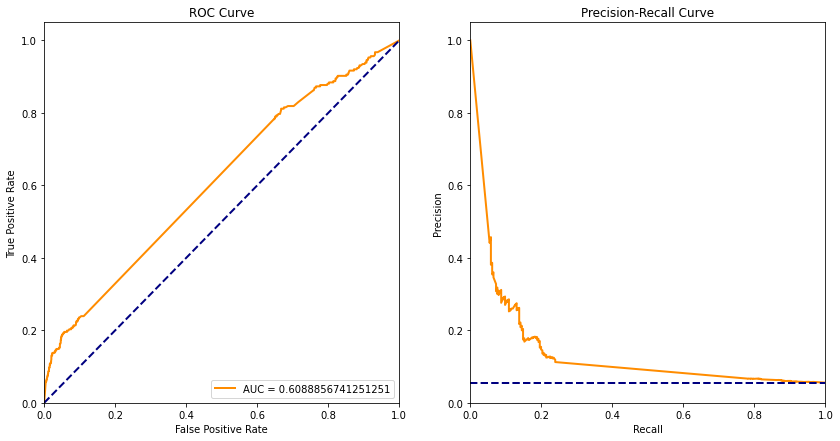

TFIDF Character random forest accuracy:  0.8918700827113173
TN:  4296 FP:  385 FN:  151 TP:  125
              precision    recall  f1-score   support

           0       0.97      0.92      0.94      4681
           1       0.25      0.45      0.32       276

    accuracy                           0.89      4957
   macro avg       0.61      0.69      0.63      4957
weighted avg       0.93      0.89      0.91      4957



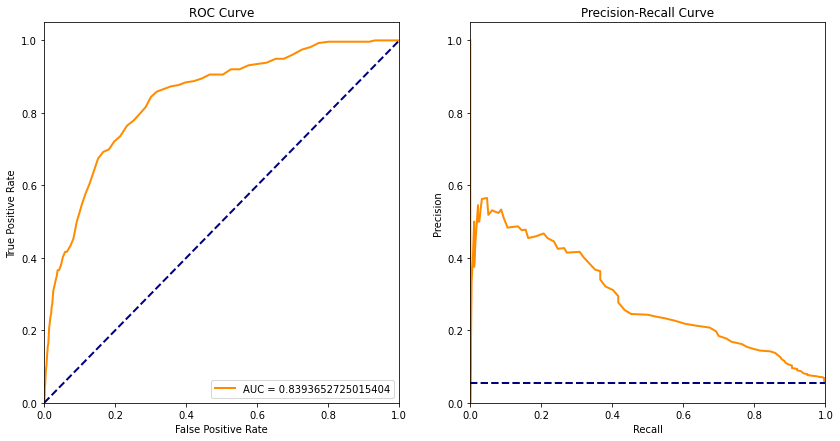

Character Embeddings random forest accuracy:  0.7076861004639903
TN:  3414 FP:  1267 FN:  182 TP:  94
              precision    recall  f1-score   support

           0       0.95      0.73      0.82      4681
           1       0.07      0.34      0.11       276

    accuracy                           0.71      4957
   macro avg       0.51      0.53      0.47      4957
weighted avg       0.90      0.71      0.79      4957



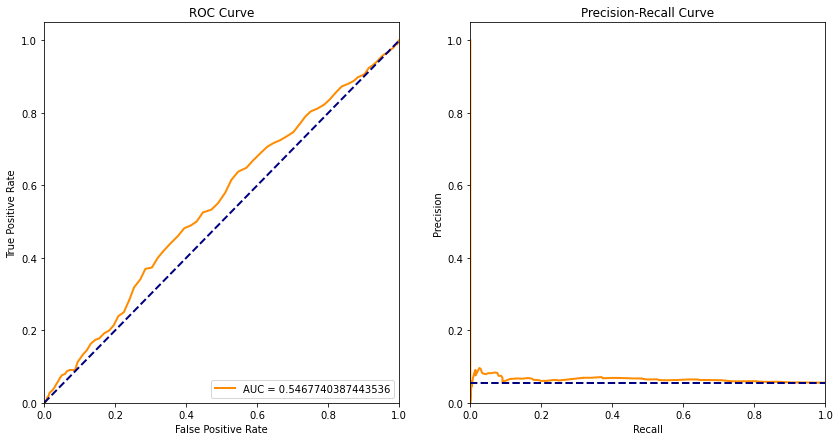

Document Embeddings random forest accuracy:  0.849381714980742
TN:  4080 FP:  582 FN:  161 TP:  110
              precision    recall  f1-score   support

           0       0.96      0.88      0.92      4662
           1       0.16      0.41      0.23       271

    accuracy                           0.85      4933
   macro avg       0.56      0.64      0.57      4933
weighted avg       0.92      0.85      0.88      4933



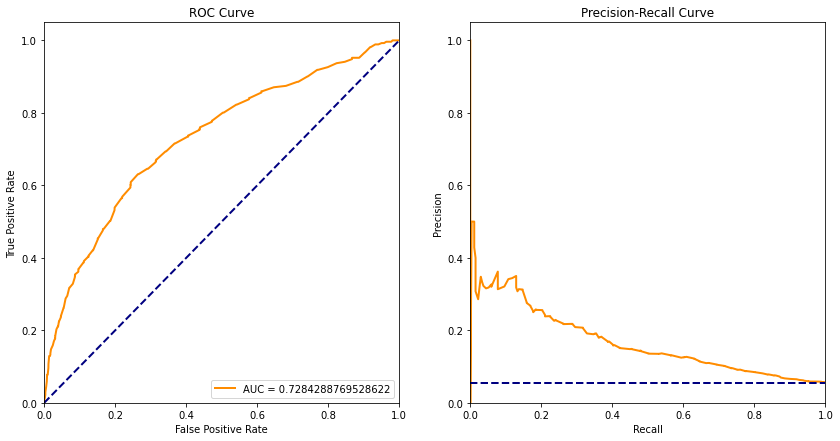

In [ ]:
rf = models.RandomForestModel()

#TFIDF Word
rf.fit(word_X_train, word_y_train)
score, preds, raw_preds = rf.predict(word_X_test, word_y_test)
print("TFIDF word random forest accuracy: ", score)
metrics.binary_metrics(word_y_test, raw_preds, preds)

#TFIDF Character
rf.fit(char_X_train, char_y_train)
score, preds, raw_preds = rf.predict(char_X_test, char_y_test)
print("TFIDF Character random forest accuracy: ", score)
metrics.binary_metrics(char_y_test, raw_preds, preds)

#Character Embeddings
rf.fit(char_emb_X_train, char_emb_y_train)
score, preds, raw_preds = rf.predict(char_emb_X_test, char_emb_y_test)
print("Character Embeddings random forest accuracy: ", score)
metrics.binary_metrics(char_emb_y_test, raw_preds, preds)

#Document Embeddings
rf.fit(doc_emb_X_train, doc_emb_y_train)
score, preds, raw_preds = rf.predict(doc_emb_X_test, doc_emb_y_test)
print("Document Embeddings random forest accuracy: ", score)
metrics.binary_metrics(doc_emb_y_test, raw_preds, preds)

3) Support Vector Machine

Support vector machines (SVM) were the next model implemented. SVMs use hinge loss as a loss function. This is effective for focusing on data points on the margin.

We chose to use SVMs because they often work very well with high dimensional data. For certain vectorization techniques that we used, the number of features would far surpass the number of samples. We expected SVMs to do particularly well in these scenarios.

The original model parameters (pre-hyperparameter tuning) included:

`C` = 1

`kernel` = 'rbf'

`gamma` = 'scale'

`probability` = True

`random_state` = 0

This model was trained as shown below:

In [ ]:
print(type(doc_emb_X_train))
print(type(doc_emb_y_train))
print(type(doc_emb_X_test))
print(type(doc_emb_y_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


<class 'numpy.matrix'>
<class 'numpy.ndarray'>
TFIDF Word SVM accuracy:  0.8801694573330644
TN:  4303 FP:  378 FN:  216 TP:  60
              precision    recall  f1-score   support

           0       0.95      0.92      0.94      4681
           1       0.14      0.22      0.17       276

    accuracy                           0.88      4957
   macro avg       0.54      0.57      0.55      4957
weighted avg       0.91      0.88      0.89      4957



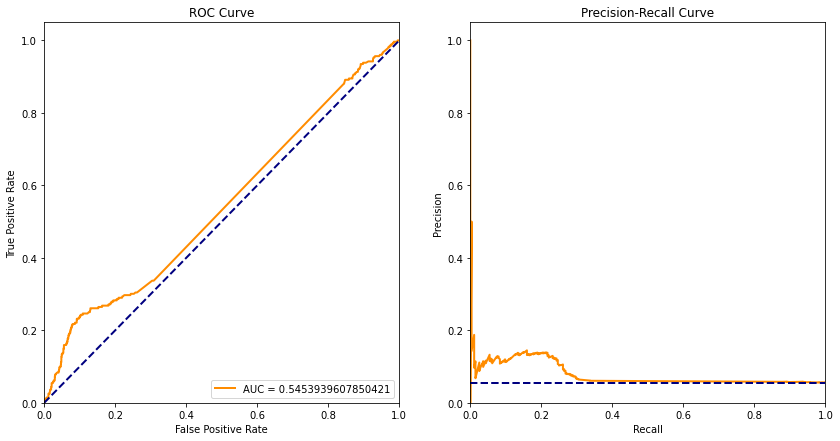

<class 'numpy.matrix'>
<class 'numpy.ndarray'>
TFIDF Character SVM accuracy:  0.8898527335081703
TN:  4257 FP:  424 FN:  122 TP:  154
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      4681
           1       0.27      0.56      0.36       276

    accuracy                           0.89      4957
   macro avg       0.62      0.73      0.65      4957
weighted avg       0.93      0.89      0.91      4957



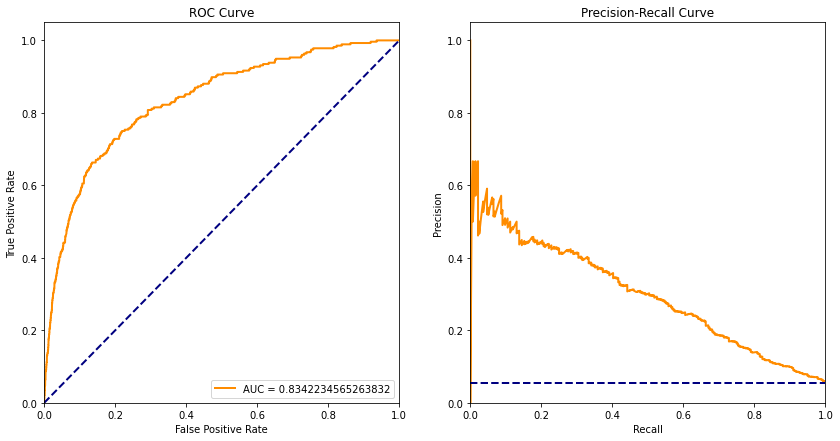

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Character Embeddings SVM accuracy:  0.19810369174904177
TN:  737 FP:  3944 FN:  31 TP:  245
              precision    recall  f1-score   support

           0       0.96      0.16      0.27      4681
           1       0.06      0.89      0.11       276

    accuracy                           0.20      4957
   macro avg       0.51      0.52      0.19      4957
weighted avg       0.91      0.20      0.26      4957



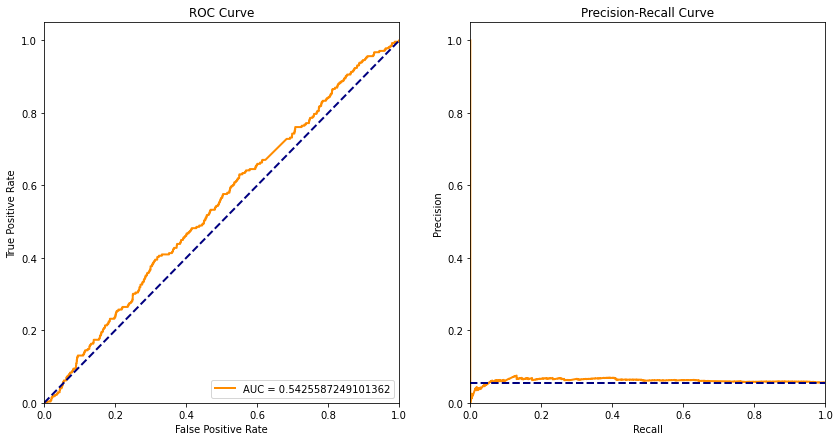

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Document Embeddings SVM accuracy:  0.7293736063247517
TN:  3423 FP:  1239 FN:  96 TP:  175
              precision    recall  f1-score   support

           0       0.97      0.73      0.84      4662
           1       0.12      0.65      0.21       271

    accuracy                           0.73      4933
   macro avg       0.55      0.69      0.52      4933
weighted avg       0.93      0.73      0.80      4933



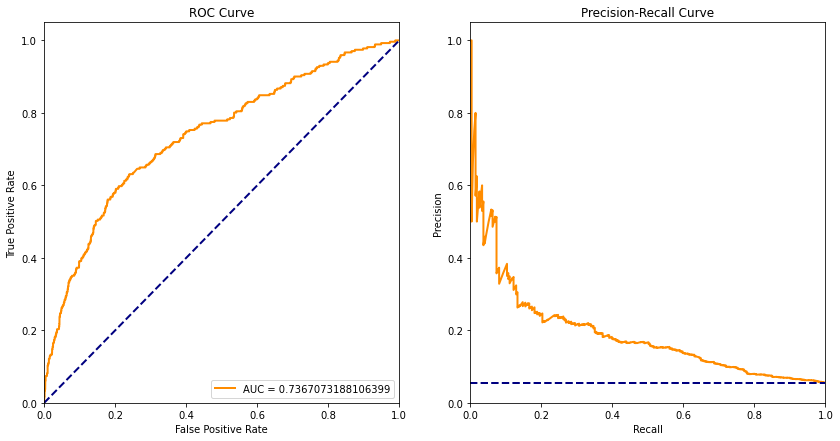

In [ ]:
svm = models.SVMModel()

#TFIDF Word
svm.fit(word_X_train.todense(), word_y_train)
score, preds, raw_preds = svm.predict(word_X_test.todense(), word_y_test)
print("TFIDF Word SVM accuracy: ", score)
metrics.binary_metrics(word_y_test, raw_preds, preds)

#TFIDF Character
svm.fit(char_X_train, char_y_train)
score, preds, raw_preds = svm.predict(char_X_test.todense(), char_y_test)
print("TFIDF Character SVM accuracy: ", score)
metrics.binary_metrics(char_y_test, raw_preds, preds)

#Character Embeddings
svm.fit(char_emb_X_train, char_emb_y_train)
score, preds, raw_preds = svm.predict(char_emb_X_test, char_emb_y_test)
print("Character Embeddings SVM accuracy: ", score)
metrics.binary_metrics(char_emb_y_test, raw_preds, preds)

#Document Embeddings
svm.fit(doc_emb_X_train, doc_emb_y_train)
score, preds, raw_preds = svm.predict(doc_emb_X_test, doc_emb_y_test)
print("Document Embeddings SVM accuracy: ", score)
metrics.binary_metrics(doc_emb_y_test, raw_preds, preds)

4) AdaBoost

Next, we implemented AdaBoost. AdaBoost is a unique model that is not fully understood. The loss function for AdaBoost could be throught of as exponential loss, however there are additional elements going on behind the scenes, as AdaBoost also leads to the minimization of test error. We did not experiment with additional loss functions.

We included AdaBoost in the project because it is a very powerful model that is easy to implement, is very fast, and does not overfit.

The original model parameters (pre-hyperparameter tuning) included:

`base_estimator` = DecisionTreeClassifier(max_depth=1)

`n_estimators` = 50

`learning_rate` = 1

This model was trained as shown below:

TFIDF word Adaboost accuracy:  0.9308049223320557
TN:  4590 FP:  91 FN:  252 TP:  24
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      4681
           1       0.21      0.09      0.12       276

    accuracy                           0.93      4957
   macro avg       0.58      0.53      0.54      4957
weighted avg       0.91      0.93      0.92      4957



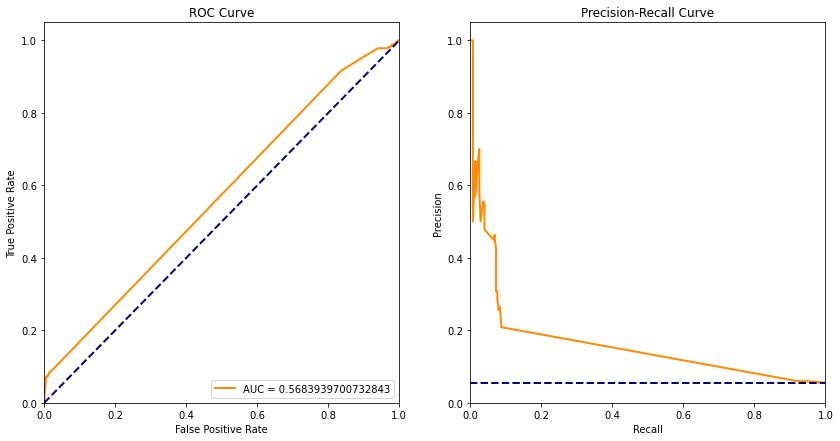

TFIDF Character Adaboost accuracy:  0.7853540447851524
TN:  3719 FP:  962 FN:  102 TP:  174
              precision    recall  f1-score   support

           0       0.97      0.79      0.87      4681
           1       0.15      0.63      0.25       276

    accuracy                           0.79      4957
   macro avg       0.56      0.71      0.56      4957
weighted avg       0.93      0.79      0.84      4957



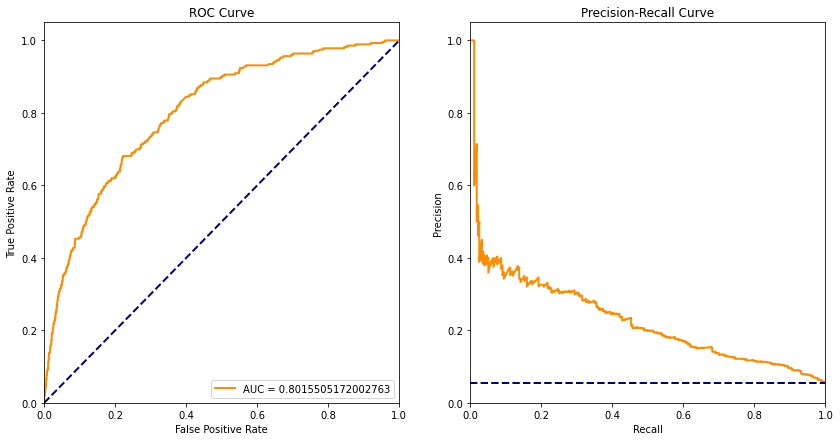

Character Embeddings Adaboost accuracy:  0.520274359491628
TN:  2418 FP:  2263 FN:  115 TP:  161
              precision    recall  f1-score   support

           0       0.95      0.52      0.67      4681
           1       0.07      0.58      0.12       276

    accuracy                           0.52      4957
   macro avg       0.51      0.55      0.39      4957
weighted avg       0.91      0.52      0.64      4957



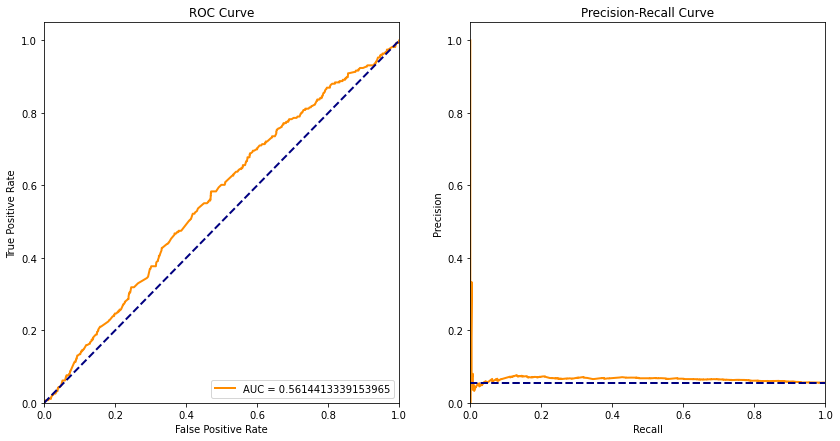

Document Embeddings Adaboost accuracy:  0.6523413744171903
TN:  3053 FP:  1609 FN:  106 TP:  165
              precision    recall  f1-score   support

           0       0.97      0.65      0.78      4662
           1       0.09      0.61      0.16       271

    accuracy                           0.65      4933
   macro avg       0.53      0.63      0.47      4933
weighted avg       0.92      0.65      0.75      4933



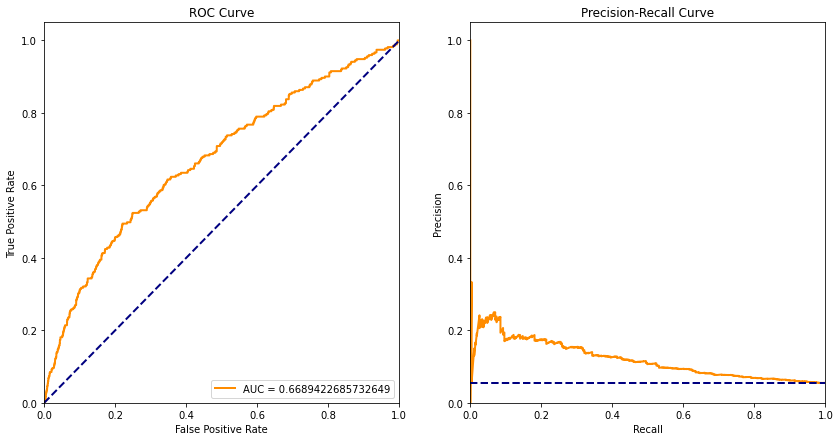

In [ ]:
ada = models.AdaBoostModel()

#TFIDF Word
ada.fit(word_X_train, word_y_train)
score, preds, raw_preds = ada.predict(word_X_test, word_y_test)
print("TFIDF word Adaboost accuracy: ", score)
metrics.binary_metrics(word_y_test, raw_preds, preds)

#TFIDF Character
ada.fit(char_X_train, char_y_train)
score, preds, raw_preds = ada.predict(char_X_test, char_y_test)
print("TFIDF Character Adaboost accuracy: ", score)
metrics.binary_metrics(char_y_test, raw_preds, preds)

#Character Embeddings
ada.fit(char_emb_X_train, char_emb_y_train)
score, preds, raw_preds = ada.predict(char_emb_X_test, char_emb_y_test)
print("Character Embeddings Adaboost accuracy: ", score)
metrics.binary_metrics(char_emb_y_test, raw_preds, preds)

#Document Embeddings
ada.fit(doc_emb_X_train, doc_emb_y_train)
score, preds, raw_preds = ada.predict(doc_emb_X_test, doc_emb_y_test)
print("Document Embeddings Adaboost accuracy: ", score)
metrics.binary_metrics(doc_emb_y_test, raw_preds, preds)

5) Multilayer Perceptron

Next, we moved on to a multilayer perceptron (MLP). An MLP is built on a combination of perceptrons. In our model, we user ReLu activation functions for hidden layers and a sigmoid activation function for the output layer. We also experimented using BCE (binary cross entropy) WithLogitsLoss, which is a loss function that combines a sigmoid layer with BCELoss.

MLPs were used because they are flexible, very powerful, and have a global estimating hypothesis class.

Our original network was built using:

- 2 Hidden Layers

- Dropout of 0.1 (after all layers)

- Batch Normalization

`batch_size` = 64

`epochs` = 10

`learning_rate` = 0.001

The network is trained as shown below:



cpu
binaryClassification(
  (layer_1): Linear(in_features=574, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Epoch 001: | Loss: 0.58587 | Acc: 67.631
Epoch 002: | Loss: 0.50479 | Acc: 73.062
Epoch 003: | Loss: 0.48519 | Acc: 73.575
Epoch 004: | Loss: 0.47464 | Acc: 73.850
Epoch 005: | Loss: 0.46388 | Acc: 74.850
Epoch 006: | Loss: 0.46083 | Acc: 74.625
Epoch 007: | Loss: 0.45306 | Acc: 74.756
Epoch 008: | Loss: 0.44854 | Acc: 75.006
Epoch 009: | Loss: 0.44946 | Acc: 74.888
Epoch 010: | Loss: 0.44610 | Acc: 74.894
TN:  1665 FP:  3016 FN:  60 TP:  216
              precision    recall  f1-score   support

           0       0.97 

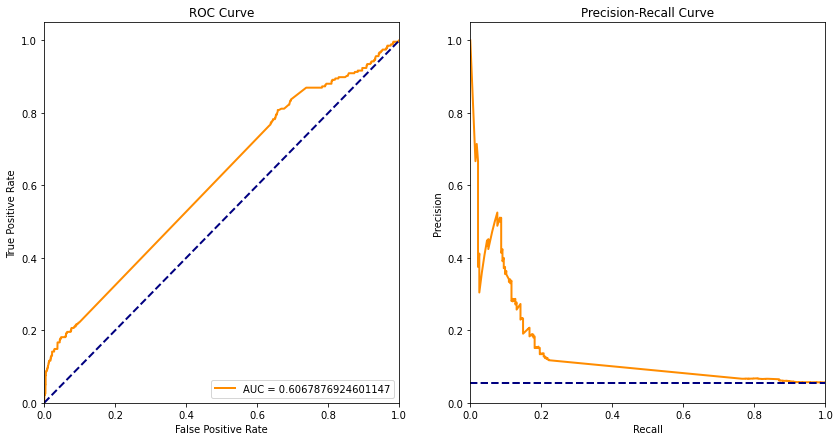

cpu
binaryClassification(
  (layer_1): Linear(in_features=868, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Epoch 001: | Loss: 0.44952 | Acc: 79.263
Epoch 002: | Loss: 0.23205 | Acc: 91.606
Epoch 003: | Loss: 0.13580 | Acc: 95.369
Epoch 004: | Loss: 0.07900 | Acc: 97.338
Epoch 005: | Loss: 0.04911 | Acc: 98.312
Epoch 006: | Loss: 0.04259 | Acc: 98.537
Epoch 007: | Loss: 0.03997 | Acc: 98.500
Epoch 008: | Loss: 0.03057 | Acc: 98.975
Epoch 009: | Loss: 0.02747 | Acc: 98.919
Epoch 010: | Loss: 0.02559 | Acc: 99.106
TN:  3547 FP:  1134 FN:  100 TP:  176
              precision    recall  f1-score   support

           0       0.97

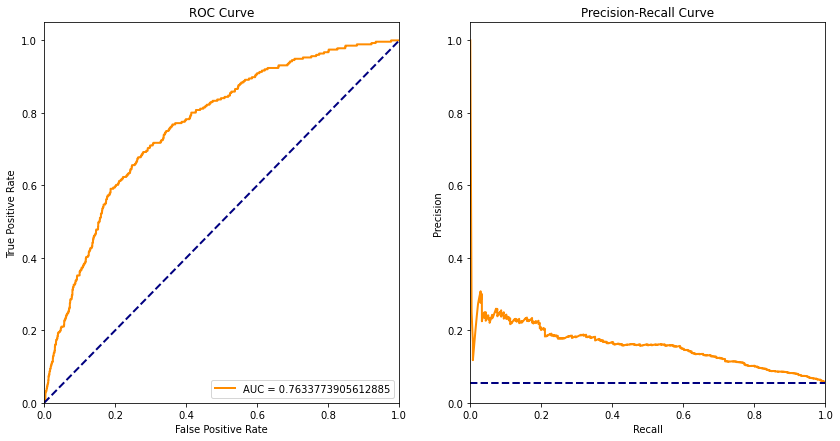

cpu
binaryClassification(
  (layer_1): Linear(in_features=5, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Epoch 001: | Loss: 0.68448 | Acc: 56.975
Epoch 002: | Loss: 0.67251 | Acc: 58.456
Epoch 003: | Loss: 0.66797 | Acc: 58.975
Epoch 004: | Loss: 0.66431 | Acc: 59.888
Epoch 005: | Loss: 0.66248 | Acc: 59.812
Epoch 006: | Loss: 0.66033 | Acc: 59.956
Epoch 007: | Loss: 0.65827 | Acc: 60.100
Epoch 008: | Loss: 0.65502 | Acc: 60.362
Epoch 009: | Loss: 0.65666 | Acc: 60.694
Epoch 010: | Loss: 0.65690 | Acc: 60.962
TN:  2204 FP:  2477 FN:  87 TP:  189
              precision    recall  f1-score   support

           0       0.96   

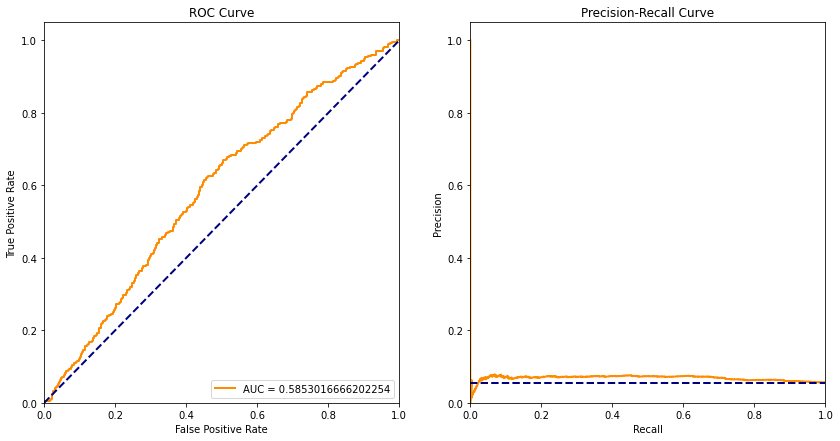

cpu
binaryClassification(
  (layer_1): Linear(in_features=50, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=64, bias=True)
  (layer_out): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Epoch 001: | Loss: 0.60014 | Acc: 67.994
Epoch 002: | Loss: 0.53258 | Acc: 73.472
Epoch 003: | Loss: 0.49163 | Acc: 76.755
Epoch 004: | Loss: 0.46892 | Acc: 77.855
Epoch 005: | Loss: 0.43607 | Acc: 80.503
Epoch 006: | Loss: 0.40724 | Acc: 82.044
Epoch 007: | Loss: 0.39256 | Acc: 82.560
Epoch 008: | Loss: 0.36396 | Acc: 84.308
Epoch 009: | Loss: 0.34157 | Acc: 85.566
Epoch 010: | Loss: 0.33253 | Acc: 85.887
TN:  3125 FP:  1537 FN:  108 TP:  163
              precision    recall  f1-score   support

           0       0.97 

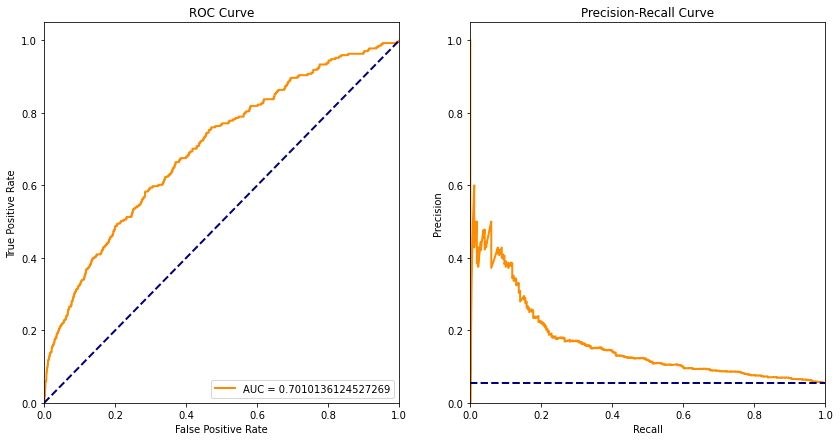

In [ ]:
#TFIDF Word
scaler = StandardScaler()
NN_X_train = scaler.fit_transform(word_X_train.todense())
NN_X_test = scaler.fit_transform(word_X_test.todense())

train_data = models.trainData(torch.FloatTensor(NN_X_train), torch.FloatTensor(word_y_train))
test_data = models.testData(torch.FloatTensor(NN_X_test))

train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

model = models.train_neural_net(train_loader, 10, 0.001, word_X_train.shape)

preds, raw_preds = models.test_neural_net(model, test_loader)

metrics.binary_metrics(word_y_test, raw_preds, preds)

#TFIDF Character
scaler = StandardScaler()
NN_X_train = scaler.fit_transform(char_X_train)
NN_X_test = scaler.fit_transform(char_X_test.todense())

train_data = models.trainData(torch.FloatTensor(NN_X_train), torch.FloatTensor(char_y_train))
test_data = models.testData(torch.FloatTensor(NN_X_test))

train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

model = models.train_neural_net(train_loader, 10, 0.001, char_X_train.shape)

preds, raw_preds = models.test_neural_net(model, test_loader)

metrics.binary_metrics(char_y_test, raw_preds, preds)

#Character Embeddings
scaler = StandardScaler()
NN_X_train = scaler.fit_transform(char_emb_X_train)
NN_X_test = scaler.fit_transform(char_emb_X_test)

train_data = models.trainData(torch.FloatTensor(NN_X_train), torch.FloatTensor(char_emb_y_train))
test_data = models.testData(torch.FloatTensor(NN_X_test))

train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

model = models.train_neural_net(train_loader, 10, 0.001, char_emb_X_train.shape)

preds, raw_preds = models.test_neural_net(model, test_loader)

metrics.binary_metrics(char_emb_y_test, raw_preds, preds)

#Document Embeddings
scaler = StandardScaler()
NN_X_train = scaler.fit_transform(doc_emb_X_train)
NN_X_test = scaler.fit_transform(doc_emb_X_test)

train_data = models.trainData(torch.FloatTensor(NN_X_train), torch.FloatTensor(doc_emb_y_train))
test_data = models.testData(torch.FloatTensor(NN_X_test))

train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

model = models.train_neural_net(train_loader, 10, 0.001, doc_emb_X_train.shape)

preds, raw_preds = models.test_neural_net(model, test_loader)

metrics.binary_metrics(doc_emb_y_test, raw_preds, preds)

6) Convolutional Neural Network

Our CNN works solely on raw tweets, so here feature extraction methods are unnecessary. As a result, we don't really have a baseline because running the CNN on raw tweets is really our only current option.

Label shape:  (24783,)
cpu
binaryCNN(
  (conv1): Conv1d(152, 10, kernel_size=(10,), stride=(1,))
  (conv2): Conv1d(10, 20, kernel_size=(20,), stride=(1,))
  (layer_1): Linear(in_features=1360, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=20, bias=True)
  (layer_out): Linear(in_features=20, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (batchnorm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Epoch 001: | Loss: 0.51477 | Acc: 77.774
Epoch 002: | Loss: 0.23061 | Acc: 94.055
Epoch 003: | Loss: 0.20372 | Acc: 94.116
Epoch 004: | Loss: 0.16594 | Acc: 94.703
Epoch 005: | Loss: 0.12177 | Acc: 95.732
Epoch 006: | Loss: 0.09478 | Acc: 96.600
Epoch 007: | Loss: 0.06786 | Acc: 97.471
Epoch 008: | Loss: 0.05824 | Acc: 97.797
Epoch 009: | Loss: 0.04476 | Acc: 98.297
Epoch 010: | Loss: 0.03332 

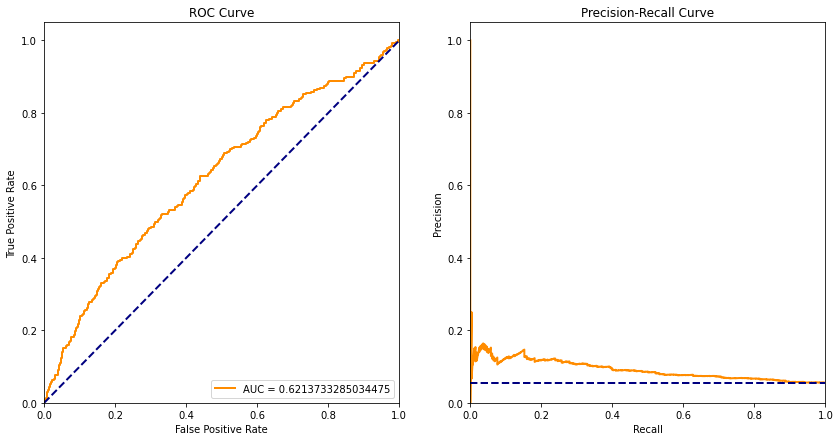

In [ ]:
from sklearn.model_selection import train_test_split

D = preprocessing.Data(DATAFILE, preprocess=False)
 
no_emojis = []
for doc in D.raw_tweets:
    no_emojis.append(D._fix_escaped_tokens(doc))

mat = models.build_cnn_matrix(no_emojis)

labels = np.array(D.labels).astype(float)
labels = np.where(labels < 0.5, 1, 0)
print('Label shape: ', labels.shape)

X_train, X_test, y_train, y_test = train_test_split(mat, labels, test_size=0.2, random_state=seed)

train_data = models.trainData(torch.FloatTensor(X_train), 
                        torch.FloatTensor(y_train))
test_data = models.testData(torch.FloatTensor(X_test))

train_loader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

model = models.train_cnn(train_loader, 10, 0.001, X_train.shape)
preds, raw_preds = models.test_neural_net(model, test_loader)
metrics.binary_metrics(y_test, raw_preds, preds)

### Results

Now that we have tested our preprocessed and vectorized data on all 6 models, we can compare results to determine the best method. Overall the model which performed the best was our Random Forest classifier using data augmentation and TFIDF char vectorizer. This model was able to produce a F1 score of 0.32 for hate speech and 0.94 for normal speech. From here we can further optimize using a random search hyperparameter sweep. 








Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 325 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 11.7min finished


Optimal RF Parameters:  {'n_estimators': 1000, 'min_samples_split': 2, 'min_impurity_decrease': 0.0, 'max_features': 'log2', 'max_depth': None, 'criterion': 'gini', 'bootstrap': False}
TFIDF Character tuned random forest accuracy:  0.9322170667742586
TN:  4519 FP:  162 FN:  174 TP:  102
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      4681
           1       0.39      0.37      0.38       276

    accuracy                           0.93      4957
   macro avg       0.67      0.67      0.67      4957
weighted avg       0.93      0.93      0.93      4957



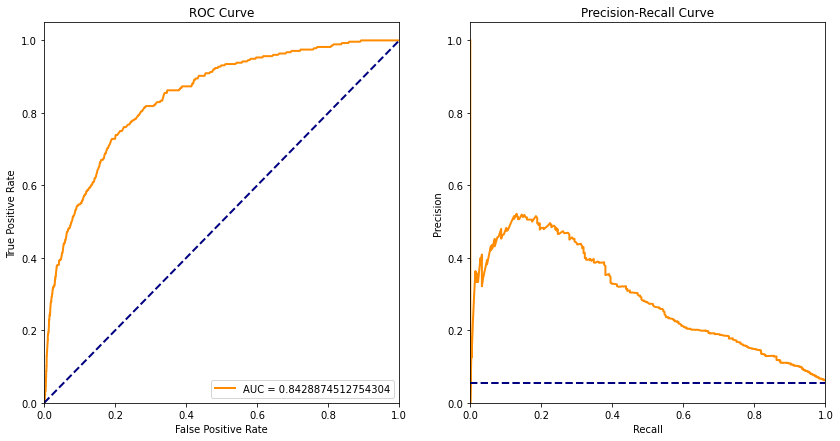

In [ ]:
############### HYPERPARAMETER SEARCH  ###############
#imports
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

#create base model for search
rf_base = RandomForestClassifier()

# Set Estimator Search Vector
rf_n_estimators = [int(x) for x in np.linspace(200,1000,5)]
rf_n_estimators.append(1500)
rf_n_estimators.append(2000)

#Set Depth Search Vector
rf_max_depth = [int(x) for x in np.linspace(5,55,11)]
rf_max_depth.append(None)

#Set Criterion Vector
rf_criterion = ['gini', 'entropy']

#set Min Sample Split Vector
rf_min_samples_split = [int(x) for x in np.linspace(2,10,9)]

#set Max_Features
rf_max_features = ['auto', 'sqrt', 'log2']
        
#Set Impurity Vector
rf_min_impurity_decrease = [0.0,0.05,0.1]

#Set Bootstrap
rf_bootstrap = [True, False]

#Create Hyperparameter Grid as Dictionary
grid = {'n_estimators': rf_n_estimators,
                     'max_depth': rf_max_depth,
                     'criterion': rf_criterion,
                     'min_samples_split': rf_min_samples_split,
                     'max_features': rf_max_features,
                     'min_impurity_decrease': rf_min_impurity_decrease,
                     'bootstrap': rf_bootstrap}

#Create random search estimator
rf_tune = RandomizedSearchCV(estimator = rf_base, param_distributions = grid, n_iter = 100, cv = 5, verbose = 2, random_state = 42, n_jobs = -1)

#TFIDF Character
rf_tune.fit(char_X_train, char_y_train)

#print the best parameters
print("Optimal RF Parameters: ", rf_tune.best_params_)

raw_preds = rf_tune.predict_proba(char_X_test)
raw_preds = raw_preds[:,1]
score = rf_tune.score(char_X_test, char_y_test)
preds = rf_tune.predict(char_X_test)

print("TFIDF Character tuned random forest accuracy: ", score)
metrics.binary_metrics(char_y_test, raw_preds, preds)

This further improvesthe F1 score to 0.38 on hate speech and to 0.96 on normal speech. While the SVM model with TFIDF Char also produces a F1 hate score of 0.36, it is significantly more compuationally expensive and hyperparamter tuning yielded no better results. Overall the discovery of the RF superiority was suprising. We initially hypothesized our NN would work better due to its univeral function approximation. We belive this result demonstrates the power and versitility of the random forest method. 
 
#### Table of Results
A table of F1 score results for both classes on every model can be found below.

|Method||Pre-Process||F1 Normal Speech||F1 Hate Speech|
|------||-----------||----------------||--------------|
|Logistic Regression||Baseline||0.97||0.10|
|Logistic Regression||TFIDF Word||0.92||0.15|
|Logistic Regression||TFIDF Char||0.88||0.26|
|Logistic Regression||Char Embed||0.53||0.11|
|Logistic Regression||Word Embed||0.80||0.17|
|Random Forest||Baseline||0.97||0.03|
|Random Forest||TFIDF Word||0.93||0.16|
|Random Forest||TFIDF Char||0.94||0.32|
|Random Forest||Char Embed||0.82||0.11|
|Random Forest||Word Embed||0.92||0.23|
|SVM||Baseline||0.97||0.03|
|SVM||TFIDF Word||0.94||0.17|
|SVM||TFIDF Char||0.94||0.36|
|SVM||Char Embed||0.27||0.11|
|SVM||Word Embed||0.84||0.21|
|AdaBoost||Baseline||0.97||0.17|
|AdaBoost||TFIDF Word||0.96||0.12|
|AdaBoost||TFIDF Char||0.87||0.25|
|AdaBoost||Char Embed||0.67||0.12|
|AdaBoost||Word Embed||0.78||0.16|
|Multi-Layer Perceptron||Baseline||0.96||0.17|
|Multi-Layer Perceptron||TFIDF Word||0.52||0.12|
|Multi-Layer Perceptron||TFIDF Char||0.85||0.22|
|Multi-Layer Perceptron||Char Embed||0.63||0.13|
|Multi-Layer Perceptron||Word Embed||0.79||0.17|
|Convolutional Network||Baseline||0.96||0.09|
|Tuned Random Forest||TFIDF Char||0.96||0.38|

Overall, the different models had very different reactions to our preprocessing methods. Even with data augmentation, document and character embeddings seemed to fail across the board. While these vectorizers fell short of the competition for logistic regression, random forest, and SVM's, they failed to surpass the baseline for adaboost and MLP. A tradeoff can be seen between TFIDF word and TFIDF char. Generally, the TFIDF char vectorizor worked better in all cases, but in some instances , such as in logistic regression, F1 score is worsened.

### FATE Analysis

FATE stands for fairness, accountability, transparency, and ethics. The principles of FATE are more prevalent in modern machine learning now than ever. With a project categorizing hate speech, there are some dramatic implications that can arise from a poorly created model.

\
#### Fairness

One of the major issues surrounding classifying hate speech is the role of freedom of speech. Freedom of speech is a constitutional right, and the lines between free speech and hate speech can become easily blurred. According to Webster's dictionary, hate speech is defined as "speech expressing hatred of a particular group of people". In our model, it is important that we correctly identify these instances of hate speech, but it is even more important that we do not falsely identify normal speech as hateful.

In general, a good method for ensuring a fair model is to check if the Positive Predictive Value (PPV) and the Negative Predictive Value (NPV) of the model are approximately equal. In addition, the False Negative Rate (FNR) and the True Positive Rate (TPR) should also be approximately equal. For our model, we also focus heavily on the number of False Positives, as incorrectly categorizing normal speech as hate speech could could result in major issues with individual rights.

Other evaluation metrics will include ROC curves and Precision-Recall curves. An ROC curve varies the decision recall threshold and observes the resluting tradeoff between FPR and TPR. This is effective for finding the optimal operating point. In our dataset with the unaugmented data, we may prefer to rely on Precision-Recall curves. These vary the same decision threshold, yet now focus on precision and recall. The benefit of this curve is it is not impacted by the number of True Negatives, which is very useful for imbalanced datasets.

Another important point for this dataset is the harm of representation. Many of the language present contains racial slurs and stereotypes. The context and the source of these words can both impact the label. This brings up issues of stereotyping, denigration, and the quality of our dataset. 

\
#### Accountability 

If actually deployed, our model would have far reaching impacts. Ideally, this model would effectively categorize hate speech the majority of the time, while rarely ever misclassifying normal language. However, in the case that our model breaches a user's freedom of speech by incorrectly misclassifying, someone must be held accountable. In this scenario, we as the developers of the model, are responsible for its deployment.

\
#### Transparency

To help our model abide by standards of transparency, it is important to carefully document and clearly label all choices in the development process. It should be clear to the public where our data comes from, how we handle the data, and the methods with which we augment the original dataset. Issues of transparency can become highly detrimental when the builders of the model cut corners to improve performance. In our case, we understand the ethical implications of this research, and will focus on making all decisions clear.

\
#### Ethics

Lastly, ethics becomes an important problem for our model. At the conclusion of this project, we must ask the question: Do we feel comfortable releasing this model to the public? With our current progress, we are pleased with the success of the model on the provided and augmented data. However, a fully deployable model still has a long way to go.

Due to the potentially dramatic consequenses of a poor hate speech model, we believe our model should be further improved before deployment. To do so, we suggest the following:

- Obtain more high quality data. For a truly successful model, the data must be highly representative of typical tweets.

- Create more accurate labels. At the moment, each label is the consensus of three voters. This can be ambiguous, and a larger group of qualified individuals would be preferred.

- Train with more advanced models and better augmentation techniques. With additional computing power, we believe the success of the model can continue to rise.


## 4. Discussion

We learned a lot from this project about Twitter, machine learning, and NLP. Firstly, we learned that bag-of-words methods are inherently limited- they do not perform particularly well when trying to determine the sentiment of a string of text because they ignore potentially important structure in the text. Sequential methods, such as an LSTM, would work far better in this regard.  Secondly, performing classification on heavily imbalanced data sets is very difficult, and great care must be taken when approaching pre-processing and feature selection. While our method of data augmentation did work well to increase accuracy scores across the board, it did not provide enough improvement to justify the implementation of this model in a commercial environment. Thirdly, we learned just how powerful the random forest model can be, outperforming all of our other models including the more sophisticated and adaptive neural networks. 

\
We believe our models may be slightly overfitting because of the limitations of our dataset. There are very few examples of true hate speech, which makes it hard to learn a generalizable rule for recognizing hate speech. Additionally, while our data augmentation was effective for generating additional hate speech examples, it did not generate examples that were substantially different from the originals, which limited its impact on the model performance.

\
Some of the lecture content that was most relevant for our project were the lectures on classification, feature extraction, and homework 4’s TFIDF method for preprocessing text data. We were able to select classifiers that we believed would have the best success given the type of data we were seeing without having to implement more complicated sequential architectures. Similarly, the feature extraction lab along with our experience with TFIDF gave us a great starting point for discovering different types of vectorization techniques. 

\
For future machine learning projects, we can borrow many of the techniques learned from our study. One of the most important lessons learned was the importance of establishing distinct project tasks, rather than just rushing into model-building. In this project, we spent a majority of time preprocessing and vectorizing our text, yet neglected visualizing and understanding our raw data. In hindsight, this would have been a good first step for understanding our data. Had we spent more time on this step, we could have been better prepared for issues encountered later in the project, such as the quantity of special characters/emojis in the data and the dramatic impact of the raw class imbalance.

\
Given two more weeks to work on this project, we would try to improve our existing models by adding more features related to the linguistic structure of the tweets, such as sentiment, part of speech tagging, dependency parsing, and maybe even semantic parsing. We also would like to try a sequential model like a GRU, which is more computationally efficient than an LSTM but still performs well at encoding relationships between words in sequential data. 

\
Lastly, a major issue encountered in our project was the long runtime for many of our models due to high computational complexity. To solve this issue, we could utilize accelerated computing. This would be very helpful for experimenting with additional hyperparameter tuning and implementing different parameters for our vectorizers. In addition, faster computing would let us try different preprocessing schemes, such as including certain special characters and emojis.



## 5. References



*   [1] Mathew, B., Kumar, N. (in press). Analyzing the hate and counter speech accounts on Twitter. Retrieved from https://arxiv.org/pdf/1812.02712.pdf 
* [2] Barendt, E. (2019, May 25). What Is the Harm of Hate Speech? Retrieved from https://link.springer.com/article/10.1007/s10677-019-10002-0 
* [3] Relia, K., Li, Z. (in press). Race, Ethnicity and National Origin-based Discrimination in Social Media and Hate Crimes Across 100 U.S. Cities. Retrieved from https://arxiv.org/abs/1902.00119 
* [4] Davidson, T., Warmsley, D. (in press). Automated Hate Speech Detection and the Problem of Offensive Language. Retrieved from https://arxiv.org/abs/1703.04009 
* [5] Mikolav, T., Sutskever, I. (n.d.). Distributed Representations of Words and Phrases and their Compositionality. Conference on Neural Information Processing Systems. Retrieved from https://papers.nips.cc/paper/2013/file/9aa42b31882ec039965f3c4923ce901b-Paper.pdf 
* [6] Vosoughi, S. Tweet2Vec. (2016) Proceedings of the 39th International ACM SIGIR Conference on Research and Development in Information Retrieval - SIGIR doi:10.1145/2911451.2914762. 
* [7] Sklearn Feature Extraction TfidfVectorizer¶. (n.d.). Retrieved November 07, 2020, from https://scikit learn.org/stable/modules/generated/sklearn.featureextraction.text.T f idfV ectorizer.html 
* [8] Caruana, R., Lawrence, S. (2000). Overfitting in neural nets: Backpropagation, conjugate gradient, and early stopping. Conference on Neural Information Processing Systems.


